# 2021 Fantasy Football

### GOAL: to create a draft assistant that selects and ideal lineup

### What is needed or data required
- historical data for player and team performance
- depth charts

### Methods
- linear regression
- XGBoost
- other ML techniques

## Data

### Fetching and Loading Data - Previous Year's Fantasy Football Results

In [1]:
from bs4 import BeautifulSoup
import os
import pandas as pd
import requests
from tqdm import tqdm

In [2]:
# fetch and/or load historical FF performance data

force_update = False

YEARS = [2020, 2019, 2018, 2017, 2016]
URL_FF_START = 'https://www.pro-football-reference.com/years/'
URL_FF_END = '/fantasy.htm'

# checking if data already exists ========================================
FETCH = False
FOUND_YEARS = []

for year in YEARS:
    if os.path.isfile(f'./data/{year}_ff_rankings.csv'):
        FOUND_YEARS.append(year)

if set(FOUND_YEARS) != set(YEARS):
    GET_YEARS = []
    for year in YEARS:
        if year not in FOUND_YEARS:
            GET_YEARS.append(year)
    FETCH = True
# ========================================================================
if FETCH or force_update:
    print('Gathering data...')
    
    # check if folder exists, if not, create it
    if os.path.isdir('./data') is False:
        os.mkdir('data')

    for year in tqdm(GET_YEARS):
        r = requests.get(URL_FF_START + str(year) + URL_FF_END, 'lxml')
        df = pd.read_html(r.text, index_col=0)[0]

        # fixing column names ============================================
        df.columns = df.columns.to_flat_index()
        df.columns = ["_".join(x) for x in df.columns]
        
        for col in df.columns:
            if col[:3] == 'Unn':
                df.rename(columns={col: col.split('_')[-1]}, inplace=True)
        # ================================================================
        
        # other various fixes
        df = df[df['Tm'] != 'Tm']
        
        df[df.columns[4:]] = df[df.columns[4:]].fillna(value=0)
        
        df['FantPos'] = df['FantPos'].fillna('UNKN')
        df['FantPos'] = df['FantPos'].apply(lambda x: str(x).upper())
        
        df['Player'] = df['Player'].apply(lambda x: x.replace('*', ' '))
        df['Player'] = df['Player'].apply(lambda x: x.replace('+', ' '))
        df['Player'] = df['Player'].apply(lambda x: x.strip().upper())
        
        df.to_csv(f'./data/{year}_ff_rankings.csv')

# loading in data
ffranks_dfs = []
for year in YEARS:
    year_df = pd.read_csv(f'./data/{year}_ff_rankings.csv', index_col=0)
    year_df['for_year'] = year

    ffranks_dfs.append(year_df)
        
ffrank_df = pd.concat(ffranks_dfs, ignore_index=True)

'''
Can now access individual year frames or a combined frame. Most likely,
just want to access the combine frame, so I'll only clean that
'''

ffrank_df.head()
    

,Player,Tm,FantPos,Age,Games_G,Games_GS,Passing_Cmp,Passing_Att,Passing_Yds,Passing_TD,...,Scoring_2PM,Scoring_2PP,Fantasy_FantPt,Fantasy_PPR,Fantasy_DKPt,Fantasy_FDPt,Fantasy_VBD,Fantasy_PosRank,Fantasy_OvRank,for_year
0,DERRICK HENRY,TEN,RB,26,16,16,0,0,0,0,...,1,0,314,333.1,341.1,323.6,184,1,1,2020
1,ALVIN KAMARA,NOR,RB,25,15,10,0,0,0,0,...,0,0,295,377.8,383.8,336.3,165,2,2,2020
2,DALVIN COOK,MIN,RB,25,14,14,0,0,0,0,...,3,0,294,337.8,346.8,315.8,164,3,3,2020
3,TRAVIS KELCE,KAN,TE,31,15,15,1,2,4,0,...,1,0,208,312.8,316.8,260.3,117,1,4,2020
4,DAVANTE ADAMS,GNB,WR,28,14,14,0,0,0,0,...,0,0,243,358.4,362.4,300.9,117,1,5,2020


### Data Cleaning

In [3]:
# converting columns to necessary types - may be a bit overkill
types_dict = {'Player': str, 'Tm': str, 'FantPos': str, 'Age': int,
              'Games_G': int, 'Games_GS': int, 'Passing_Cmp': float,
              'Passing_Att': int, 'Passing_Yds': float, 'Passing_TD': int,
              'Passing_Int': int, 'Rushing_Att': int, 'Rushing_Yds': float,
              'Rushing_Y/A': float, 'Rushing_TD': float, 'Receiving_Tgt': int,
              'Receiving_Rec': int, 'Receiving_Yds': float, 'Receiving_Y/R': float,
              'Receiving_TD': int, 'Fumbles_Fmb': int, 'Fumbles_FL': int,
              'Scoring_TD': int, 'Scoring_2PM': int, 'Scoring_2PP': int,
              'Fantasy_FantPt': float, 'Fantasy_PPR': float, 'Fantasy_DKPt': float,
              'Fantasy_FDPt': float, 'Fantasy_VBD': float, 'Fantasy_PosRank': int,
              'Fantasy_OvRank': int, 'for_year': int}

ffrank_df = ffrank_df.astype(types_dict)

## EDA

Questions:
- Which age would be considered prime? Does this change by position?
- Which positions produce the most fantasy points?
- Which positions does quality matter most?
    - for instance, is there a greater disparity in quality amongst QBs than RBs?

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline 

In [5]:
MIN_GAMES = 8

ffrank_df = ffrank_df[ffrank_df['Games_G'] >= MIN_GAMES]
ffrank_df['FantPt/G'] = ffrank_df['Fantasy_FantPt'] / ffrank_df['Games_G']

'''
Discriminating against large outliers here (optional).
Not using data where FantPt/G is less than 2
'''
ffrank_df = ffrank_df[ffrank_df['FantPt/G'] >= 2]

### Athlete's Prime

In [6]:
prime_df = ffrank_df[['FantPos', 'Player', 'Age', 'FantPt/G', 'Fantasy_FantPt']]
min_age = prime_df['Age'].min()
max_age = prime_df['Age'].max()

age_dict = {}
for i in range(min_age, max_age+1):
    _series = prime_df[prime_df['Age'] == i]['FantPt/G']
    if len(_series) >= 30:
        mean = _series.mean()
        std = _series.std()
        age_dict[i] = {'mean': mean, 'std': std}

agg_prime_df = pd.DataFrame.from_dict(age_dict, orient='index')
agg_prime_df

,mean,std
21,7.805873,4.315697
22,7.160204,4.969406
23,7.579948,5.068403
24,7.186751,4.677274
25,7.340344,4.824195
26,6.813567,4.030773
27,6.706318,3.677787
28,7.182914,4.579523
29,7.721045,4.880262
30,7.664189,3.939402


Text(0.5, 1.0, 'Fantasy Points vs. Age')

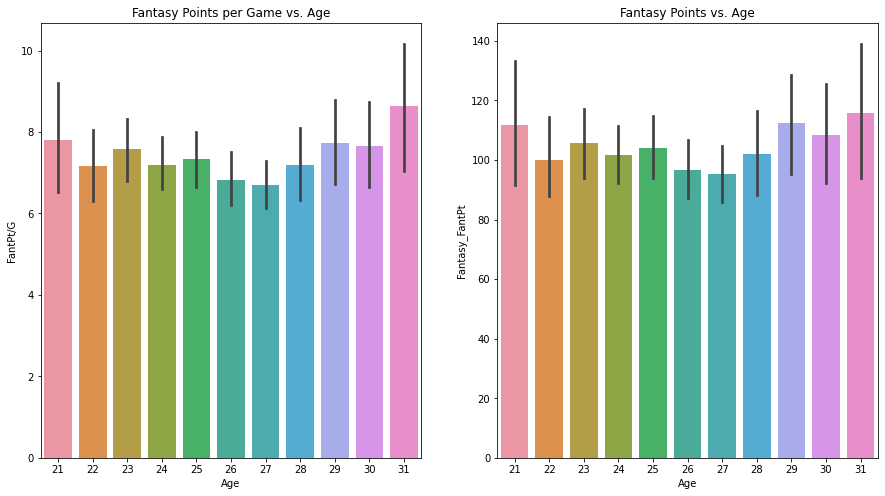

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

sns.barplot(x="Age", y="FantPt/G", data=prime_df[prime_df['Age']<=31], ax=ax1)
ax1.set_title('Fantasy Points per Game vs. Age')

sns.barplot(x="Age", y="Fantasy_FantPt", data=prime_df[prime_df['Age']<=31], ax=ax2)
ax2.set_title('Fantasy Points vs. Age')


Text(0.5, 1.0, 'Fantasy Points vs. Age (QBs)')

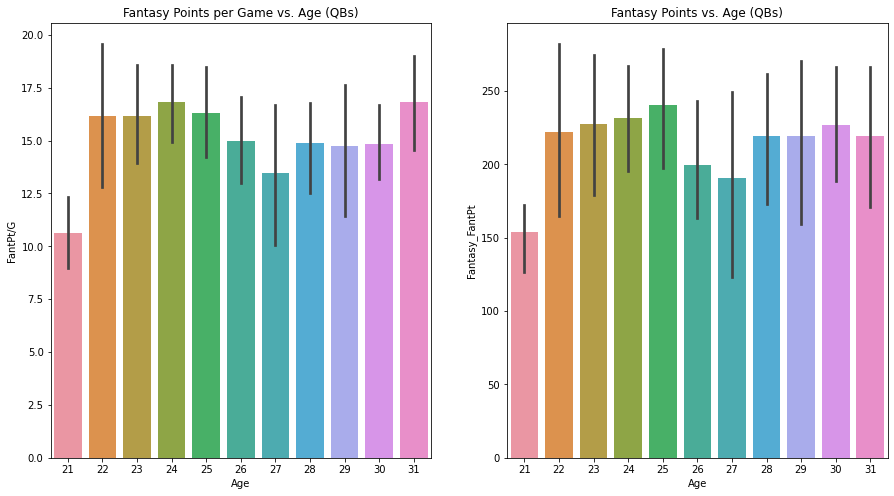

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

_qb_prime_df = prime_df[prime_df['Age']<=31]
qb_prime_df = _qb_prime_df[_qb_prime_df['FantPos'] == 'QB']

sns.barplot(x="Age", y="FantPt/G", data=qb_prime_df, ax=ax1)
ax1.set_title('Fantasy Points per Game vs. Age (QBs)')

sns.barplot(x="Age", y="Fantasy_FantPt", data=qb_prime_df, ax=ax2)
ax2.set_title('Fantasy Points vs. Age (QBs)')

Text(0.5, 1.0, 'Fantasy Points vs. Age (RBs)')

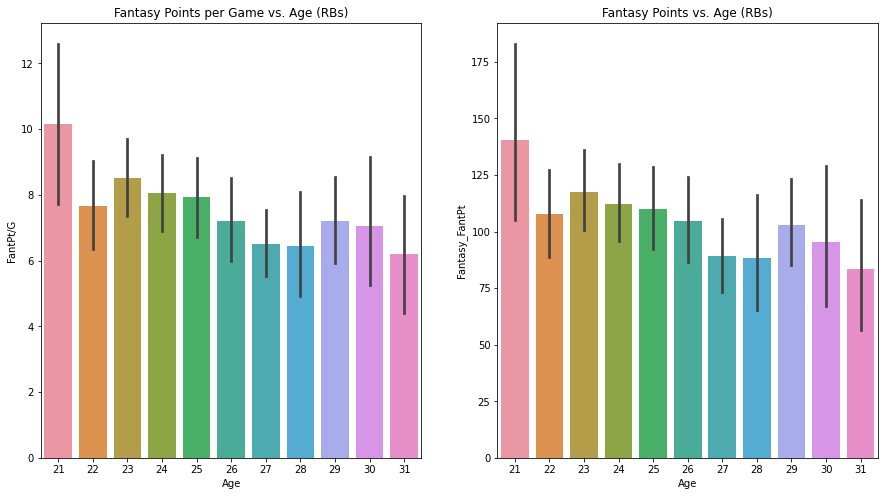

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

_rb_prime_df = prime_df[prime_df['Age']<=31]
rb_prime_df = _rb_prime_df[_rb_prime_df['FantPos'] == 'RB']

sns.barplot(x="Age", y="FantPt/G", data=rb_prime_df, ax=ax1)
ax1.set_title('Fantasy Points per Game vs. Age (RBs)')

sns.barplot(x="Age", y="Fantasy_FantPt", data=rb_prime_df, ax=ax2)
ax2.set_title('Fantasy Points vs. Age (RBs)')

Text(0.5, 1.0, 'Fantasy Points vs. Age (WRs)')

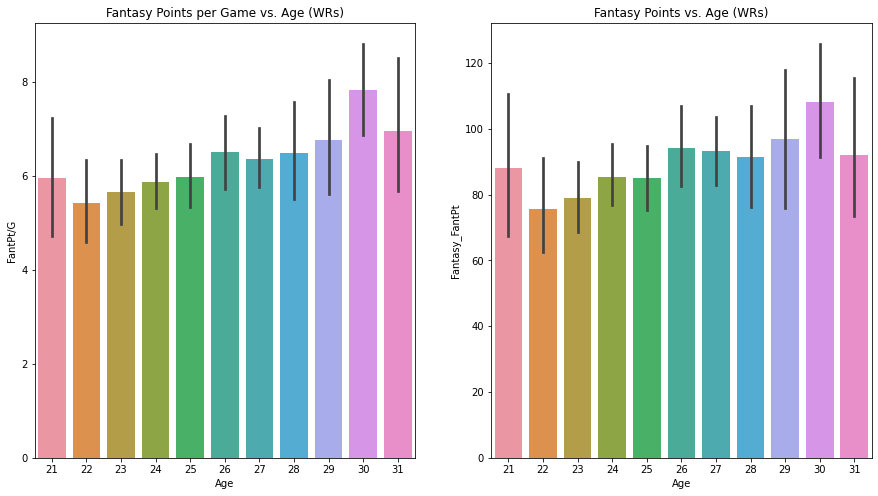

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

_wr_prime_df = prime_df[prime_df['Age']<=31]
wr_prime_df = _wr_prime_df[_wr_prime_df['FantPos'] == 'WR']

sns.barplot(x="Age", y="FantPt/G", data=wr_prime_df, ax=ax1)
ax1.set_title('Fantasy Points per Game vs. Age (WRs)')

sns.barplot(x="Age", y="Fantasy_FantPt", data=wr_prime_df, ax=ax2)
ax2.set_title('Fantasy Points vs. Age (WRs)')

Text(0.5, 1.0, 'Fantasy Points vs. Age (TEs)')

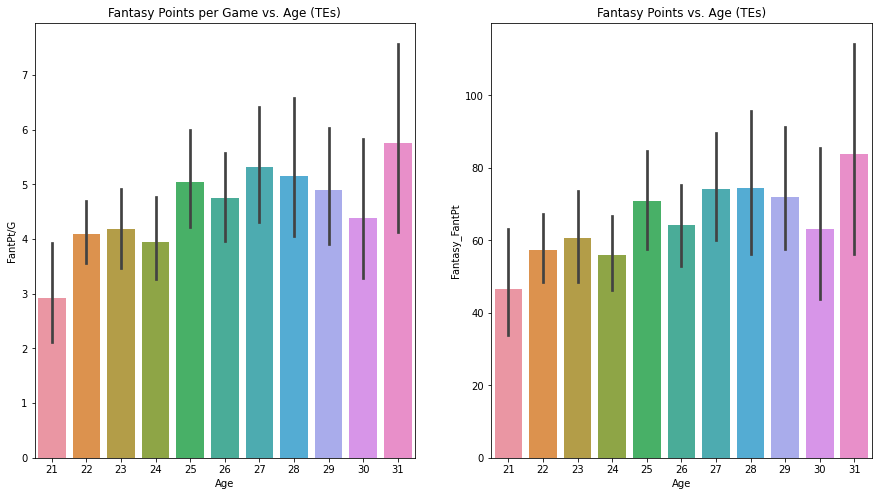

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

_te_prime_df = prime_df[prime_df['Age']<=31]
te_prime_df = _te_prime_df[_te_prime_df['FantPos'] == 'TE']

sns.barplot(x="Age", y="FantPt/G", data=te_prime_df, ax=ax1)
ax1.set_title('Fantasy Points per Game vs. Age (TEs)')

sns.barplot(x="Age", y="Fantasy_FantPt", data=te_prime_df, ax=ax2)
ax2.set_title('Fantasy Points vs. Age (TEs)')

### Position

In [12]:
pos_df = ffrank_df[['FantPos', 'Player', 'Age', 'FantPt/G', 'Fantasy_FantPt', 'Games_G']]

Text(0.5, 1.0, 'Total Fantasy Points (QBs)')

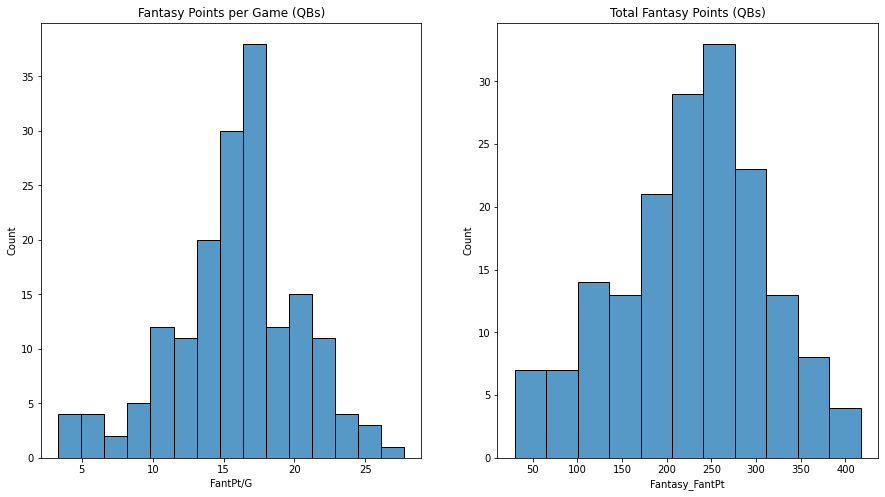

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

qb_pos_df = pos_df[pos_df['FantPos'] == 'QB']

sns.histplot(x="FantPt/G", data=qb_pos_df, ax=ax1)
ax1.set_title('Fantasy Points per Game (QBs)')

sns.histplot(x="Fantasy_FantPt", data=qb_pos_df, ax=ax2)
ax2.set_title('Total Fantasy Points (QBs)')

In [14]:
qb_pos_df.describe()

,Age,FantPt/G,Fantasy_FantPt,Games_G
count,172.000000,172.000000,172.000000,172.000000
mean,28.808140,15.904968,226.918605,13.912791
std,5.387156,4.463482,83.993346,2.597448
min,21.000000,3.333333,30.000000,8.000000
25%,24.000000,13.484375,174.750000,12.000000
50%,28.000000,16.312500,240.000000,15.000000
75%,32.000000,18.175000,282.000000,16.000000
max,43.000000,27.733333,417.000000,16.000000


Text(0.5, 1.0, 'Total Fantasy Points (RBs)')

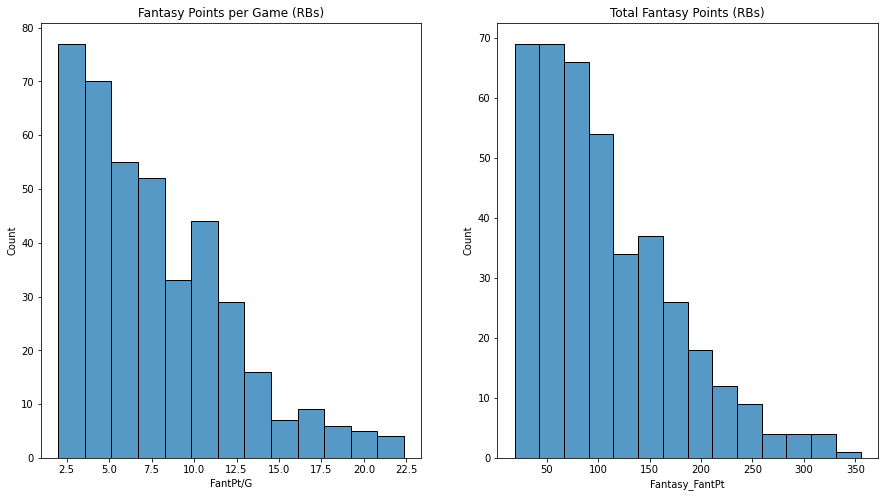

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

rb_pos_df = pos_df[pos_df['FantPos'] == 'RB']

sns.histplot(x="FantPt/G", data=rb_pos_df, ax=ax1)
ax1.set_title('Fantasy Points per Game (RBs)')

sns.histplot(x="Fantasy_FantPt", data=rb_pos_df, ax=ax2)
ax2.set_title('Total Fantasy Points (RBs)')

In [16]:
rb_pos_df.describe()

,Age,FantPt/G,Fantasy_FantPt,Games_G
count,407.000000,407.000000,407.000000,407.000000
mean,25.319410,7.643769,106.464373,13.781327
std,2.906794,4.400728,66.351082,2.377821
min,21.000000,2.000000,19.000000,8.000000
25%,23.000000,4.226496,54.000000,12.000000
50%,25.000000,6.769231,89.000000,14.000000
75%,27.000000,10.187500,145.000000,16.000000
max,37.000000,22.357143,355.000000,16.000000


Text(0.5, 1.0, 'Total Fantasy Points (WRs)')

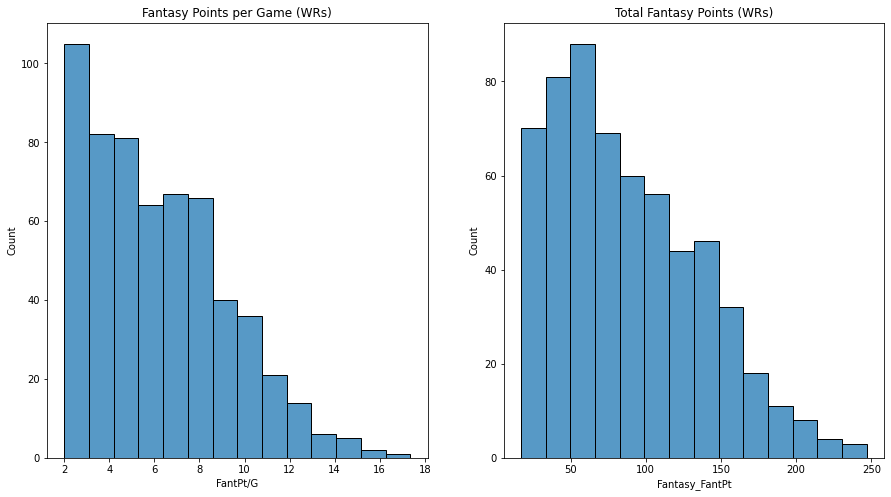

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

wr_pos_df = pos_df[pos_df['FantPos'] == 'WR']

sns.histplot(x="FantPt/G", data=wr_pos_df, ax=ax1)
ax1.set_title('Fantasy Points per Game (WRs)')

sns.histplot(x="Fantasy_FantPt", data=wr_pos_df, ax=ax2)
ax2.set_title('Total Fantasy Points (WRs)')

In [19]:
wr_pos_df.describe()

,Age,FantPt/G,Fantasy_FantPt,Games_G
count,590.000000,590.000000,590.000000,590.000000
mean,25.818644,6.194278,88.193220,14.005085
std,2.923355,3.060093,48.395407,2.407185
min,21.000000,2.000000,17.000000,8.000000
25%,24.000000,3.603846,49.000000,13.000000
50%,25.000000,5.875000,79.000000,15.000000
75%,27.000000,8.250000,121.500000,16.000000
max,37.000000,17.357143,247.000000,17.000000


Text(0.5, 1.0, 'Total Fantasy Points (TEs)')

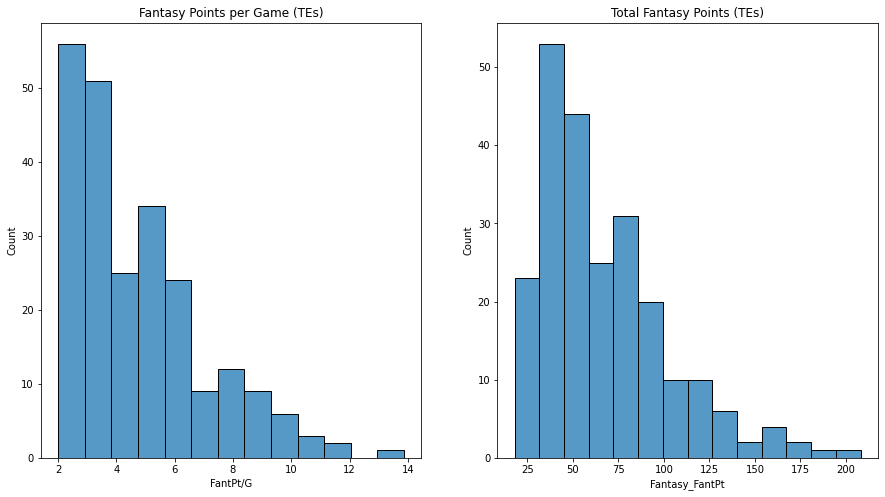

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

te_pos_df = pos_df[pos_df['FantPos'] == 'TE']

sns.histplot(x="FantPt/G", data=te_pos_df, ax=ax1)
ax1.set_title('Fantasy Points per Game (TEs)')

sns.histplot(x="Fantasy_FantPt", data=te_pos_df, ax=ax2)
ax2.set_title('Total Fantasy Points (TEs)')

In [21]:
te_pos_df.describe()

,Age,FantPt/G,Fantasy_FantPt,Games_G
count,232.000000,232.000000,232.000000,232.000000
mean,27.012931,4.737652,67.275862,14.185345
std,3.587473,2.288653,34.948840,2.371394
min,21.000000,2.000000,18.000000,8.000000
25%,24.000000,2.937500,41.000000,13.000000
50%,26.000000,4.080128,56.500000,15.000000
75%,29.000000,5.823661,84.250000,16.000000
max,38.000000,13.866667,208.000000,16.000000
